In [785]:
from collections import Counter
import matplotlib.pyplot as plt
import nltk
from pathlib import Path
import pylangacq

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maxreuter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [786]:
# Load the corpora into individual readers, plus a combined reader.
# Loading may take several seconds.

data_path = Path('data')
corpora_paths = sorted(data_path.glob('*.zip'), key=lambda x: x.name.lower())
corpora_names = [path.stem for path in corpora_paths]

readers = {name: pylangacq.read_chat(str(path)) for name, path in zip(corpora_names, corpora_paths)}

In [787]:
# Ages range from 21-145 months, and for now we are bucketing every 3 months.

lowest_age  = 21
highest_age = 145
increment   = 3

age_buckets = list(range(lowest_age, highest_age + increment, increment))
readers_by_age = {age: pylangacq.Reader() for age in age_buckets}

In [788]:
# Reorganize corpora readers into readers per age bucket, combining corpora at ages if necessary.
# Also, discard any data points with missing or invalid age data.

data_discard_counters = {name: {'total': 0, 'None': 0, '0': 0} for name in corpora_names}
for corpus_name, reader in readers.items():
    while True:
        try:
            single_instance_reader = reader.pop()
            age = single_instance_reader.ages(months=True)[0]
            if age is None:
                data_discard_counters[corpus_name]['None'] += 1
                continue
            age_bucket = round(age / increment) * increment
            if age_bucket not in age_buckets:
                data_discard_counters[corpus_name]['None'] += 1
                continue

            data_discard_counters[corpus_name]['total'] += 1
            readers_by_age[age_bucket].append(single_instance_reader)
        except IndexError:
            break

# Loop through each corpus and print discard frequency.
for corpus_name, counter in data_discard_counters.items():
    num_discarded     = counter.get('None', 0) + counter.get('0', 0)
    total             = counter.get('total', 0)
    percent_discarded = 100 * num_discarded / counter.get('total', 0)
    print(f"Discarded {num_discarded} of {total} ({percent_discarded:.1f}%) datapoints from {corpus_name} corpus due to missing or invalid age data.")

# Print totals across all corpora.
total_datapoints  = sum(counter.get('total', 0) for counter in data_discard_counters.values())
total_discarded   = sum(counter.get('None', 0) + counter.get('0', 0) for counter in data_discard_counters.values())
percent_discarded = 100 * total_discarded / total_datapoints
print(f"\nIn total, discarded {total_discarded} of {total_datapoints} ({percent_discarded:.1f}%) datapoints.")

Discarded 0 of 100 (0.0%) datapoints from Bates corpus due to missing or invalid age data.
Discarded 7 of 508 (1.4%) datapoints from Champaign corpus due to missing or invalid age data.
Discarded 0 of 45 (0.0%) datapoints from Garvey corpus due to missing or invalid age data.
Discarded 1 of 39 (2.6%) datapoints from Hall corpus due to missing or invalid age data.
Discarded 110 of 1223 (9.0%) datapoints from HSLLD corpus due to missing or invalid age data.

In total, discarded 118 of 1915 (6.2%) datapoints.


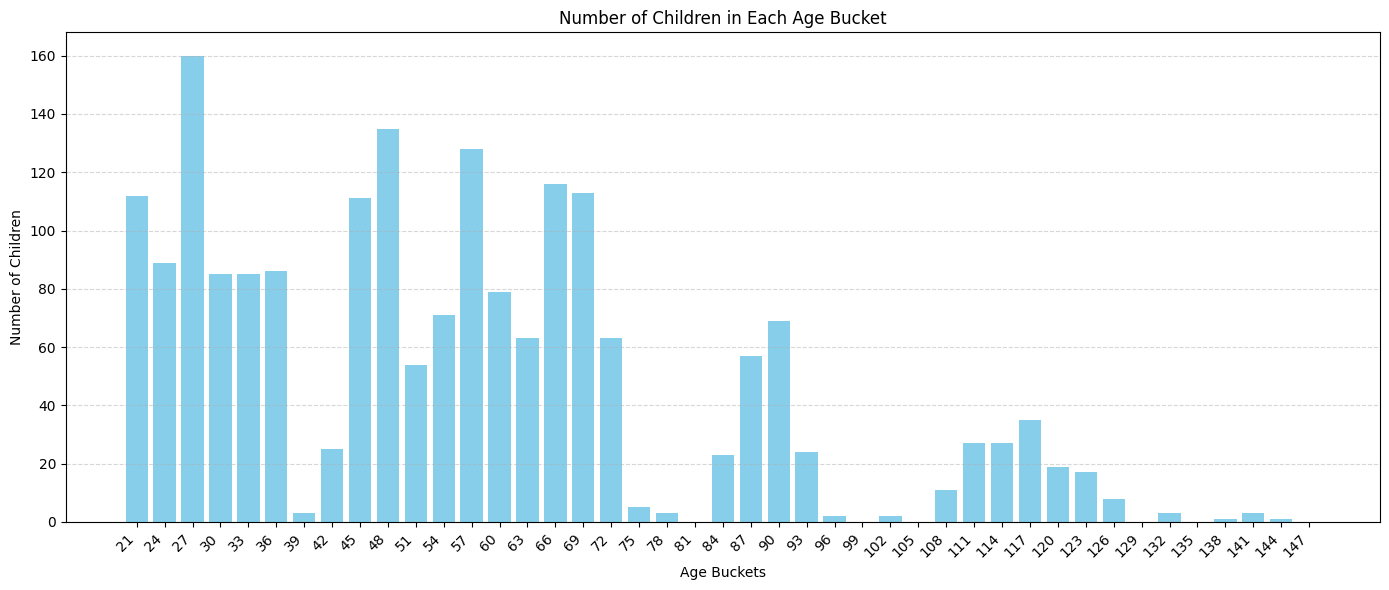

In [789]:
# Plot the number of children in each age bucket.

age_counts = [(age, len(r.ages())) for age, r in readers_by_age.items() if r is not None]
ages = [str(age) for age, _ in age_counts]
counts = [count for _, count in age_counts]

plt.figure(figsize=(14, 6))  # Increase figure size for clarity
plt.bar(ages, counts, color='skyblue')  # Use a visually appealing color

# Customize the plot
plt.xticks(rotation=45, ha='right')  # Rotate x-tick labels for better legibility
plt.xlabel('Age Buckets')
plt.ylabel('Number of Children')
plt.title('Number of Children in Each Age Bucket')
plt.grid(axis='y', linestyle='--', alpha=0.5)  # Add horizontal grid lines

# Adjust the layout
plt.tight_layout()  # Prevent x-tick labels from being cut off

plt.show()

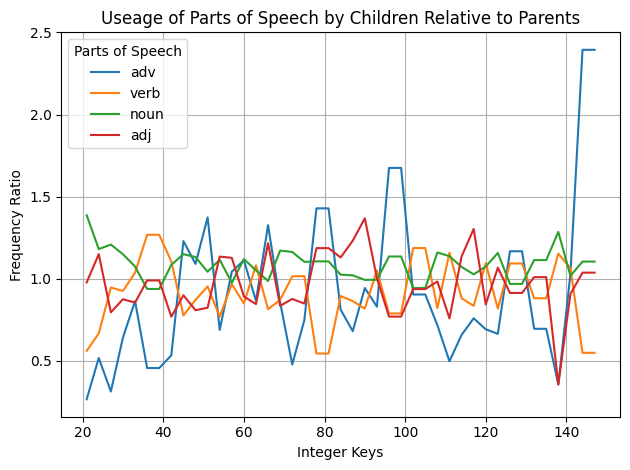

In [ ]:
# Unfortunately, not all of the corpora are already part-of-speech tagged (e.g. the Champaign corpus), so we need to do it ourselves.

pos_of_interest = ['noun', 'verb', 'adj', 'adv']
nltk_to_CHILDES_mapping = {'N': 'noun', 'V': 'verb', 'J': 'adj', 'R': 'adv'}

def remove_punctuation_and_stopwords(word_frequencies):
    [word_frequencies.pop(word, None)
        for word in
            ['.', ',', '?', '!', '...'] + 
            nltk.corpus.stopwords.words('english')]
    
    return word_frequencies

def count_relative_pos_usage(participants):
    word_frequencies = reader.word_frequencies(participants=participants)
    word_frequencies = remove_punctuation_and_stopwords(word_frequencies)

    counts = {'noun': 0, 'verb': 0, 'adj': 0, 'adv': 0}
    
    pos_tags = nltk.pos_tag(list(word_frequencies.keys()))
    
    for word, pos_code in pos_tags:
        frequency = word_frequencies[word]
        try:
            pos = nltk_to_CHILDES_mapping.get(pos_code[0])
            if pos:
                counts[pos] += frequency
        except KeyError:
            pass
    
    total_count = sum(counts.values())
    if total_count > 0:
        for pos in pos_of_interest:
            counts[f'{pos}_rel'] = counts[pos] / total_count

    return counts

ratios = {age_bucket: None for age_bucket in age_buckets}
for age, reader in readers_by_age.items():
    try:
        counts_child  = count_relative_pos_usage(participants=['CHI'])
        counts_parent = count_relative_pos_usage(participants=['MOT', 'FAT'])

        try:
            pos_usage_ratios = {pos: counts_child[f'{pos}_rel'] / counts_parent[f'{pos}_rel'] for pos in pos_of_interest}
        except KeyError:
            pass
    except ZeroDivisionError:
        pass
    
    ratios[age] = pos_usage_ratios

x = list(ratios.keys())
all_labels = set().union(*(d.keys() for d in ratios.values()))

for label in all_labels:
    y = [ratios[key][label] for key in x]
    plt.plot(x, y, label=label)

plt.title('Useage of Parts of Speech by Children Relative to Parents')
plt.xlabel('Child Age (months)')
plt.ylabel('Frequency Ratio')
plt.legend(title='Parts of Speech')
plt.grid(True)
plt.tight_layout()
plt.show()

In [798]:
# Note: the following items that use parts of speech us the ones directly from the corpus, not the ones we calculated above.

In [791]:
# Print common nouns

for age, reader in readers_by_age.items():
    print(Counter([t.word for t in reader.tokens(participants=['CHI']) if t.pos == 'noun']).most_common(10))

[('ball', 82), ('chair', 23), ('O', 16), ('bed', 15), ('people', 14), ('chicken', 13), ('Mommy', 12), ('dog', 11), ('teacher', 11), ('car', 10)]
[]
[('house', 68), ('one', 49), ('bird', 43), ('bed', 42), ('Miffy', 41), ('snow', 35), ('hat', 29), ('Mommy', 29), ('snowman', 27), ('window', 24)]
[]
[('car', 8), ('mommy', 6), ('mirror', 6), ('bottle', 6), ('baby', 4), ('one', 4), ('phone', 4), ('snake', 3), ('time', 3), ('curtains', 3)]
[('baby', 50), ('car', 24), ('truck', 23), ('school', 16), ('minute', 12), ('motor', 12), ('tractor', 12), ('Sunday', 11), ('dinner', 10), ('Daddy', 10)]
[('snake', 9), ('Superman', 9), ('one', 7), ('coffee', 7), ('baby', 6), ('comb', 6), ('truck', 5), ('hands', 5), ('side', 4), ('key', 4)]
[('zzz', 46), ('one', 30), ('baby', 25), ('snake', 21), ('ice', 19), ('piece', 19), ('cat', 19), ('cream', 18), ('car', 15), ('mommy', 15)]
[('zzz', 436), ('Mom', 142), ('one', 133), ('Mommy', 101), ('cat', 95), ('car', 93), ('dog', 88), ('Mama', 58), ('school', 57), ('b

In [792]:
# Print common verbs

for age, reader in readers_by_age.items():
    print(Counter([t.word for t in reader.tokens(participants=['CHI']) if t.pos == 'verb']).most_common(10))

[('go', 11), ('done', 7), ('see', 5), ('sit', 5), ('do', 3), ('play', 3), ('goes', 3), ('get', 2), ('look', 2), ('want', 2)]
[]
[('go', 126), ('want', 41), ('get', 38), ('see', 37), ('know', 31), ('going', 23), ('put', 22), ('play', 21), ('come', 19), ('do', 18)]
[]
[('know', 14), ('go', 9), ('get', 9), ('have', 6), ('POSTCLITIC', 5), ('work', 5), ('put', 5), ('do', 4), ('call', 4), ('clean', 4)]
[('get', 44), ('go', 32), ('have', 28), ('drive', 25), ('put', 20), ('let', 20), ('see', 18), ('got', 11), ('want', 11), ('know', 9)]
[('want', 16), ('put', 10), ('have', 10), ('broken', 10), ('going', 8), ('locked', 7), ('see', 7), ('goes', 7), ('clap', 7), ('cut', 7)]
[('go', 56), ('have', 48), ('get', 46), ('going', 45), ('put', 41), ('know', 32), ('need', 32), ('come', 30), ('see', 28), ('want', 26)]
[('want', 268), ('go', 258), ('know', 180), ('get', 149), ('have', 137), ('do', 128), ('put', 127), ('see', 124), ('got', 97), ('eat', 97)]
[('know', 228), ('go', 205), ('want', 198), ('eat', 

In [793]:
# Print common adjectives

for age, reader in readers_by_age.items():
    print(Counter([t.word for t in reader.tokens(participants=['CHI']) if t.pos == 'adj']).most_common(10))

[('more', 6), ('big', 5), ('good', 3), ('open', 3), ('little', 3), ('nice', 2), ('high', 2), ('square', 2), ('other', 1), ('asleep', 1)]
[]
[('more', 36), ('little', 20), ('good', 19), ('cold', 12), ('red', 11), ('orange', 10), ('big', 8), ('yellow', 7), ('sad', 7), ('green', 7)]
[]
[('more', 2), ('big', 2), ('tired', 2), ('okay', 2), ('tiny', 2), ('sure', 2), ('least', 2), ('good', 2), ('gracious', 1), ('tiger', 1)]
[('ready', 21), ('little', 8), ('big', 6), ('nice', 5), ('sick', 5), ('okay', 5), ('good', 4), ('new', 3), ('hot', 3), ('right', 2)]
[('other', 6), ('wrong', 2), ('better', 2), ('enough', 1), ('more', 1), ('yummy', 1), ('scrumptious', 1), ('sorry', 1), ('dirty', 1), ('big', 1)]
[('more', 28), ('other', 17), ('okay', 14), ('green', 13), ('red', 12), ('big', 11), ('yellow', 9), ('good', 8), ('blue', 7), ('orange', 6)]
[('big', 111), ('more', 78), ('little', 69), ('good', 58), ('yellow', 45), ('blue', 41), ('red', 40), ('green', 39), ('hot', 34), ('black', 33)]
[('big', 100),

In [794]:
# Print common adverbs

for age, reader in readers_by_age.items():
    print(Counter([t.word for t in reader.tokens(participants=['CHI']) if t.pos == 'adv']).most_common(10))

[('where', 20), ('there', 12), ('here', 6), ('in', 6), ("where's", 5), ('right', 4), ('up', 2), ('too', 2), ('why', 1), ('down', 1)]
[]
[('there', 99), ('here', 98), ('where', 68), ('right', 61), ('now', 22), ('in', 22), ('down', 17), ('too', 15), ("where's", 15), ('up', 14)]
[]
[('now', 22), ('here', 10), ('there', 7), ('then', 6), ('gonna', 5), ('just', 5), ('around', 4), ('on', 3), ('where', 3), ('back', 2)]
[('here', 37), ('right', 20), ('gonna', 20), ('there', 17), ("here's", 17), ('now', 15), ('where', 14), ('down', 8), ('away', 8), ('too', 7)]
[('here', 29), ('there', 16), ('then', 12), ('why', 6), ('better', 5), ("where's", 4), ('right', 4), ('just', 3), ('now', 3), ('away', 3)]
[('here', 61), ('now', 60), ('there', 46), ('too', 32), ('right', 26), ('then', 26), ('where', 23), ('gonna', 20), ("where's", 16), ('on', 13)]
[('here', 220), ('there', 181), ('gonna', 134), ('why', 124), ('now', 113), ('right', 111), ('where', 106), ('how', 81), ('too', 78), ('then', 71)]
[('here', 24

In [795]:
# Print common bigrams

filter_punctuation = lambda ngram: all([word not in ['.', ',', '?', '!', '...'] for word in ngram])
for age, reader in readers_by_age.items():
    ngrams = reader.word_ngrams(participants='CHI', n=2).most_common(10)
    print([(ngram, count) for ngram, count in ngrams if filter_punctuation(ngram)])

[]
[]
[(('I', 'want'), 427)]
[(('I', 'want'), 494)]
[(('I', 'want'), 334), (('this', 'one'), 308)]
[]
[(('this', 'is'), 55), (('is', 'mine'), 9), (('in', 'there'), 9), (('and', 'this'), 9), (('I', 'want'), 9)]
[(('I', "don't"), 36), (('going', 'to'), 29), (('you', 'can'), 26)]
[(('I', "don't"), 230), (('I', 'want'), 141), (("don't", 'know'), 115)]
[(('I', "don't"), 205)]
[(('I', "don't"), 124), (('in', 'the'), 62), (("don't", 'know'), 59)]
[(('I', "don't"), 161), (('this', 'is'), 119), (('in', 'the'), 93), (("don't", 'know'), 80)]
[(('I', "don't"), 1460), (('I', 'want'), 878)]
[(('I', "don't"), 156), (("don't", 'know'), 81), (('I', 'know'), 71)]
[(('I', "don't"), 91), (('I', 'wanna'), 56), (('I', 'know'), 55), (('going', 'to'), 54)]
[(('I', "don't"), 191), (("don't", 'know'), 112), (('this', 'is'), 105)]
[(('I', "don't"), 180), (("don't", 'know'), 98)]
[(('I', "don't"), 92), (("I'm", 'gonna'), 56), (('and', 'I'), 54)]
[(('he', 'was'), 16), (('ate', 'through'), 13), (('he', 'ate'), 12),

In [796]:
# Print common trigrams

for age, reader in readers_by_age.items():
    ngrams = reader.word_ngrams(participants='CHI', n=3).most_common(10)
    print([(ngram, count) for ngram, count in ngrams if filter_punctuation(ngram)])

[(('put', 'in', 'there'), 29), (('I', 'sit', 'down'), 18)]
[(('go', 'right', 'here'), 36)]
[(('I', "don't", 'know'), 74)]
[]
[(('I', '0am', 'gonna'), 97), (('I', "don't", 'know'), 88), (('this', 'is', 'a'), 68)]
[(('I', "don't", 'know'), 62), (('I', 'have', 'to'), 55)]
[(('this', 'is', 'mine'), 9), (('and', 'this', 'is'), 8), (('this', 'is', 'yours'), 8), (('this', 'is', 'my'), 6), (('this', 'is', 'a'), 6)]
[(("I'm", 'going', 'to'), 19), (('I', "don't", 'know'), 16), (('you', 'can', 'have'), 10), (('can', 'I', 'have'), 10), (('you', 'are', 'too'), 9)]
[(('I', "don't", 'know'), 108), (('I', 'want', 'ta'), 52), (('one', 'two', 'three'), 51), (('I', "don't", 'want'), 42), (('two', 'three', 'four'), 38), (('three', 'four', 'five'), 26)]
[(('I', "don't", 'know'), 94), (('one', 'two', 'three'), 43), (('I', "don't", 'want'), 31), (('two', 'three', 'four'), 31), (('I', "don't", 'like'), 29), (('this', 'is', 'a'), 23)]
[(('I', "don't", 'know'), 59), (('one', 'two', 'three'), 43), (('two', 'thre

In [797]:
# Print common quadgrams

for age, reader in readers_by_age.items():
    ngrams = reader.word_ngrams(participants='CHI', n=4).most_common(10)
    print([(ngram, count) for ngram, count in ngrams if filter_punctuation(ngram)])

[]
[]
[(('that', 'go', 'in', 'there'), 25)]
[]
[(('where', 'does', 'this', 'go'), 17)]
[(('and', 'this', 'is', 'the'), 14)]
[(('put', 'this', 'down', 'here'), 4), (('this', 'is', 'my', 'truck'), 3)]
[(('A', 'B', 'C', 'D'), 8), (('you', 'can', 'be', 'the'), 6), (('one', 'two', 'three', 'four'), 6), (('two', 'three', 'four', 'five'), 6), (('B', 'C', 'D', 'E'), 6), (('C', 'D', 'E', 'F'), 6), (('D', 'E', 'F', 'G'), 6), (('you', 'can', 'have', 'the'), 5)]
[(('one', 'two', 'three', 'four'), 34), (('two', 'three', 'four', 'five'), 21), (('I', "don't", 'want', 'ta'), 17), (('three', 'four', 'five', 'six'), 11), (('where', 'does', 'this', 'go'), 10), (('I', 'want', 'ta', 'play'), 10)]
[(('one', 'two', 'three', 'four'), 30), (('two', 'three', 'four', 'five'), 17), (('I', "don't", 'know', 'what'), 11), (('I', "don't", 'like', 'it'), 9), (('what', 'are', 'you', 'doing'), 9), (('going', 'to', 'the', 'zoo'), 9)]
[(('one', 'two', 'three', 'four'), 39), (('test', 'test', 'test', 'test'), 31), (('two',